# XGBoost

In [35]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

In [36]:
df_train=pd.read_json(open(r"train.json"))

In [37]:
#print(df_train.shape)

In [38]:
df_train["num_photos"]=df_train["photos"].apply(len)
df_train["num_features"]=df_train["features"].apply(len)
df_train["num_description_words"]=df_train["description"].apply(lambda x:len(x.split(" "))) #根據空白切割，去算字數
def caculate(n_words):
    description_test=[]
    for i in n_words:
        description_test.append(len(i.split(" ")))
    return description_test #效果和上面一樣
df_train["created"]=pd.to_datetime(df_train["created"])
df_train["created_year"]=df_train["created"].dt.year
df_train["created_month"] = df_train["created"].dt.month
df_train["created_day"] = df_train["created"].dt.day

In [39]:
df_train["n_description_words"]=caculate(df_train["description"])

In [40]:
#print(df_train.shape)

In [41]:
high = df_train[df_train["interest_level"] == 'high']
medium = df_train[df_train["interest_level"] == 'medium']
low = df_train[df_train["interest_level"] == 'low']
#print(len(high),len(medium),len(low))

High: 3839
Medium: 11229
Low: 34284


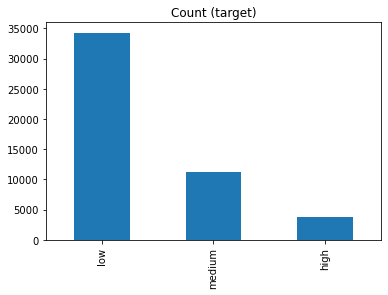

In [42]:
import matplotlib.pyplot as plt
target_count = df_train.interest_level.value_counts()
print('High:', target_count['high'])
print('Medium:', target_count['medium'])
print('Low:', target_count['low'])

target_count.plot(kind='bar', title='Count (target)');

## Over-Sampling

In [43]:
df_high = high.sample(len(low),replace=True)
df_med = medium.sample(len(low),replace=True)

## concatation and shuffle

In [44]:
df_train = pd.concat([df_high,df_med,low],axis = 0)
df_train = df_train.sample(frac=1)
#len(df_train)

High: 34284
Medium: 34284
Low: 34284


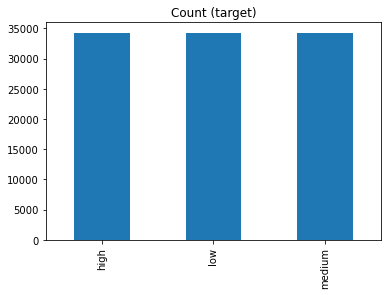

In [45]:
target_count = df_train.interest_level.value_counts()
print('High:', target_count['high'])
print('Medium:', target_count['medium'])
print('Low:', target_count['low'])

target_count.plot(kind='bar', title='Count (target)');

In [46]:
choose_columns=["bathrooms", "bedrooms", "latitude", "longitude", "price","num_photos", "num_features","num_description_words","created_year", "created_month", "created_day"]

In [47]:
X=df_train[choose_columns]
Y=df_train["interest_level"]

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

In [49]:
#XGB

clf = XGBClassifier(n_estimators=2000,min_data_in_leaf=300)
clf.fit(X_train, Y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, min_data_in_leaf=300, missing=None,
              n_estimators=2000, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

## feature selection


In [50]:
# Print the name and gini importance of each feature
from sklearn.feature_selection import SelectFromModel
for feature in zip(choose_columns, clf.feature_importances_):
    print(feature)

('bathrooms', 0.07746972)
('bedrooms', 0.23233944)
('latitude', 0.06654342)
('longitude', 0.06989846)
('price', 0.17044917)
('num_photos', 0.13454781)
('num_features', 0.09140407)
('num_description_words', 0.053474814)
('created_year', 0.0)
('created_month', 0.051545918)
('created_day', 0.052327182)


In [51]:
fs = SelectFromModel(clf, threshold=0.08)
fs.fit(X_train, Y_train)

SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=1, colsample_bynode=1,
                                        colsample_bytree=1, gamma=0,
                                        learning_rate=0.1, max_delta_step=0,
                                        max_depth=3, min_child_weight=1,
                                        min_data_in_leaf=300, missing=None,
                                        n_estimators=2000, n_jobs=1,
                                        nthread=None,
                                        objective='multi:softprob',
                                        random_state=0, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1,
                                        seed=None, silent=None, subsample=1,
                                        verbosity=1),
                max_features=None, norm_order=1, prefit=False, threshold=0.08)

## Transform the data to create a new dataset containing only the most important features
## Note: We have to apply the transform to both the training X and test X data.

In [55]:
X_important_train = fs.transform(X_train)
X_important_test = fs.transform(X_test)

In [56]:
# Create a new XGB classifier for the most important features
clf_important = XGBClassifier(n_estimators=2000,min_data_in_leaf=300)
# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, min_data_in_leaf=300, missing=None,
              n_estimators=2000, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [57]:
# Apply The Full Featured Classifier To The Test Data
from sklearn.metrics import accuracy_score
Y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print("Accuracy Without Feature Selection: ",accuracy_score(Y_test, Y_pred))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)
# View The Accuracy Of Our Limited Feature (2 Features) Model
print("Accuracy With Feature Selection: : ",accuracy_score(Y_test, y_important_pred))

Accuracy Without Feature Selection:  0.7072091779689854
Accuracy With Feature Selection: :  0.6015264206893199


## Original Classifier (Without FS)

In [58]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Y_pred,Y_test )
print('XGB Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test,Y_pred )))

XGB Model accuracy score: 0.7072


## 匯入test data

In [69]:
df_test = pd.read_json(open(r"test.json"))
#print(df_test.shape)
df_test["num_photos"] = df_test["photos"].apply(len)
df_test["num_features"] = df_test["features"].apply(len)
df_test["num_description_words"] = df_test["description"].apply(lambda x: len(x.split(" ")))
df_test["created"] = pd.to_datetime(df_test["created"])
df_test["created_year"] = df_test["created"].dt.year
df_test["created_month"] = df_test["created"].dt.month
df_test["created_day"] = df_test["created"].dt.day

x_test = df_test[choose_columns]
y_pred_test=clf.predict(x_test)#根據X_test預測該房屋有多少機率位於high low medium三個類別
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(Y_train, y_pred_train)))

Training-set accuracy score: 0.7427


## Check for Overfitting

In [61]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, Y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, Y_test)))

Training set score: 0.7427
Test set score: 0.7072


## Confusion Matrix Without FS

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion matrix\n\n', cm)


Confusion matrix

 [[5585  259 1002]
 [ 474 4748 1595]
 [1402 1291 4215]]


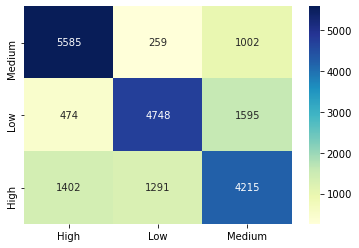

In [63]:
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['High', 'Low','Medium'], 
                                 index=['Medium', 'Low','High'])


sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Confusion Matrix With FS

Confusion matrix

 [[4761  525 1560]
 [ 904 4129 1784]
 [1951 1473 3484]]


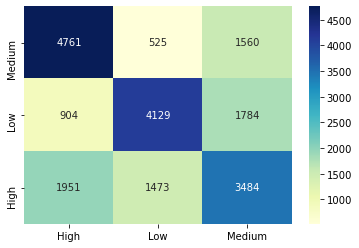

In [64]:
cm = confusion_matrix(Y_test, y_important_pred)
print('Confusion matrix\n\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['High', 'Low','Medium'], 
                                 index=['Medium', 'Low','High'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Classification Matrix Without FS

In [65]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

        high       0.75      0.82      0.78      6846
         low       0.75      0.70      0.72      6817
      medium       0.62      0.61      0.61      6908

    accuracy                           0.71     20571
   macro avg       0.71      0.71      0.71     20571
weighted avg       0.71      0.71      0.71     20571



## Classification Matrix With FS

In [66]:
print(classification_report(Y_test, y_important_pred))

              precision    recall  f1-score   support

        high       0.63      0.70      0.66      6846
         low       0.67      0.61      0.64      6817
      medium       0.51      0.50      0.51      6908

    accuracy                           0.60     20571
   macro avg       0.60      0.60      0.60     20571
weighted avg       0.60      0.60      0.60     20571

